In [42]:
#code of Interactive Quantum Classifier Inspired by Quantum Open System Theory
#LINK https://ieeexplore.ieee.org/document/9533917

#LINK https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9533917

#this code was written by Fernando Maciano de Paula Neto (fernando@cin.ufpe.br) together with Eduardo Barreto Brito (ebb2@cin.ufpe.br)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock
from helpers.icq_methods import create_and_execute_classifier

In [44]:
VARY_INPUT = "input"
VARY_BOTH = "both"
DIFFERENT_VARIATIONS = [VARY_INPUT, VARY_BOTH]

In [45]:
def generate_many_points(n_points, scale=1, dimensions = 1, varied_part=VARY_INPUT, output_func=create_and_execute_classifier):
  np.random.seed(1000)
  list_of_x = []
  list_of_y = []
  list_of_z = []
  
  for i in range(n_points):
    # We need to study what happens when we variate different things
    if varied_part == VARY_INPUT:
      i_n = scale*np.random.uniform(low=-1, high=1, size=(dimensions,))
      w_n = np.ones((dimensions,))
    elif varied_part == VARY_BOTH:
      i_n = scale*np.random.uniform(low=-1, high=1, size=(dimensions,))
      w_n = scale*np.random.uniform(low=-1, high=1, size=(dimensions,))
    
    z,p_cog = output_func(i_n, w_n)
    list_of_x.append(i_n[0])
    list_of_y.append(p_cog.real)
    list_of_z.append(z)

  return list_of_x, list_of_y, list_of_z

In [46]:
def plot_graph(list_of_x, list_of_y):
    plt.plot(list_of_x, list_of_y, color="red", marker="o",  linestyle="")
    ax = plt.gca()
    ax.tick_params(axis='y', colors='red')
    ax.tick_params(axis='x', colors='red')
    
    ax.set_xlabel("Input")
    ax.xaxis.label.set_color('red')

    ax.set_ylabel("Activation")
    ax.yaxis.label.set_color('red')
    
    plt.xticks(np.arange(-4, 4, 1))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.show()

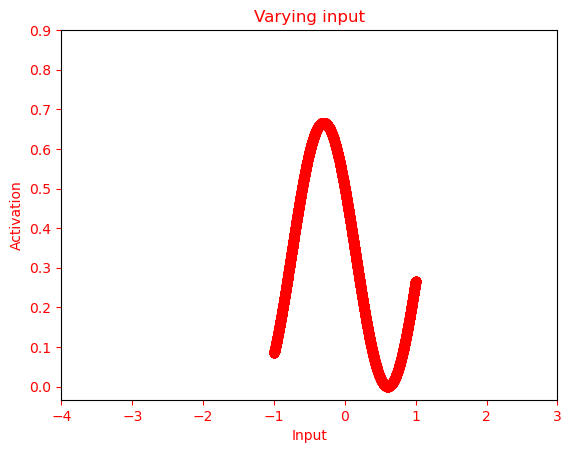

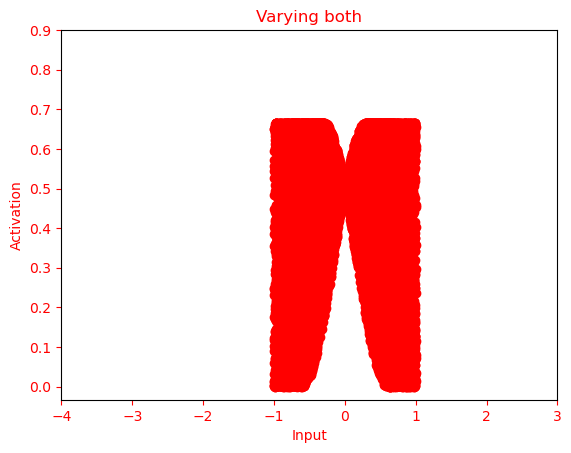

Wall time: 3.67 s


In [47]:
%%time
# First let's see only what happens when we change what we're trying to vary
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(10000, varied_part=variation)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

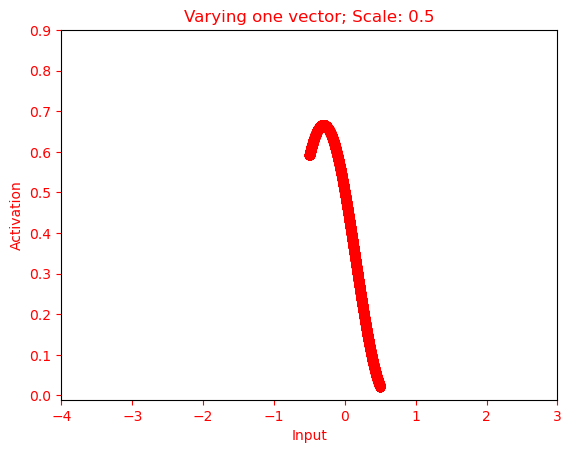

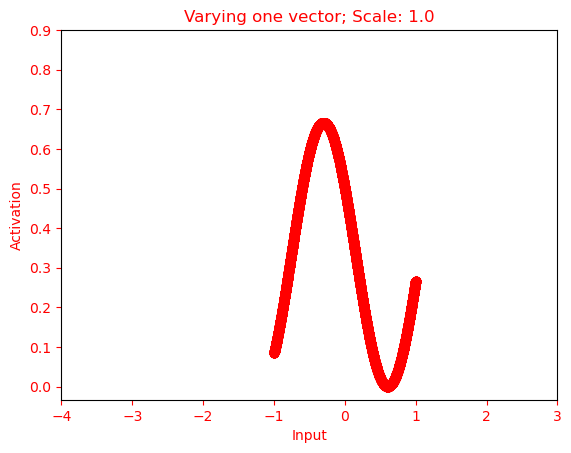

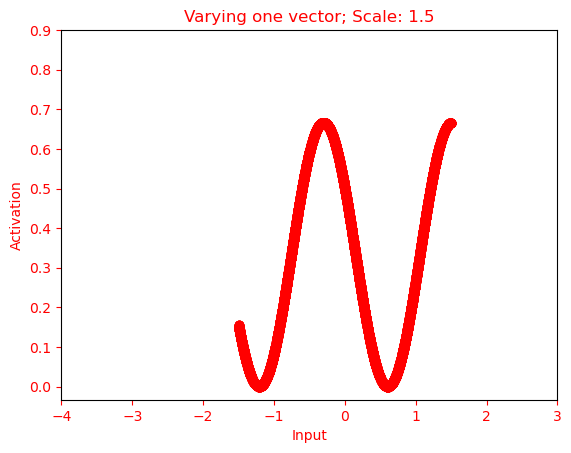

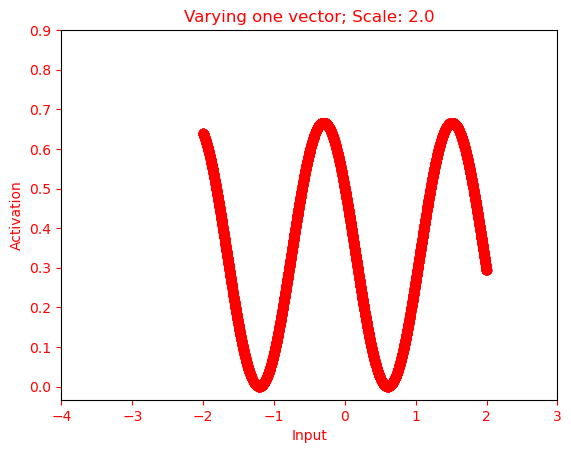

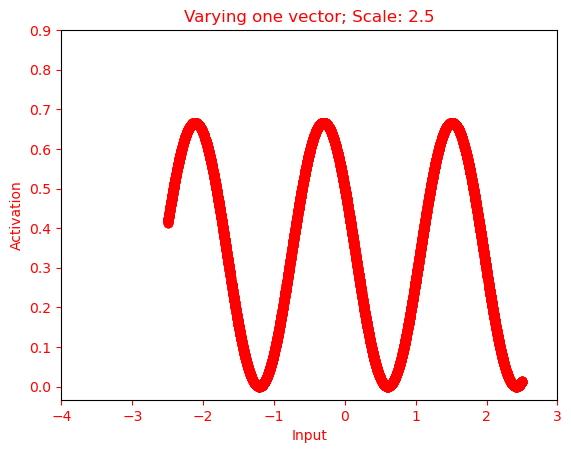

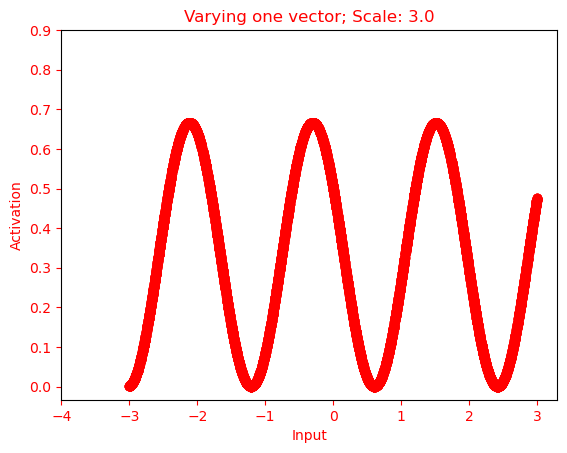

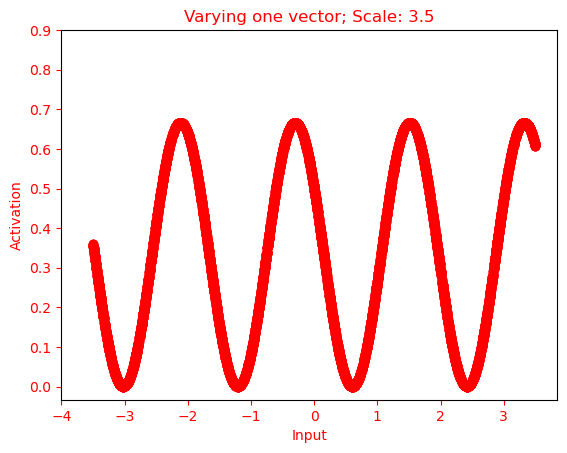

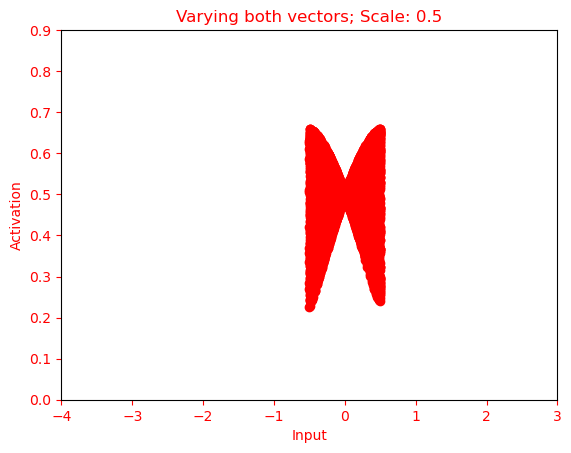

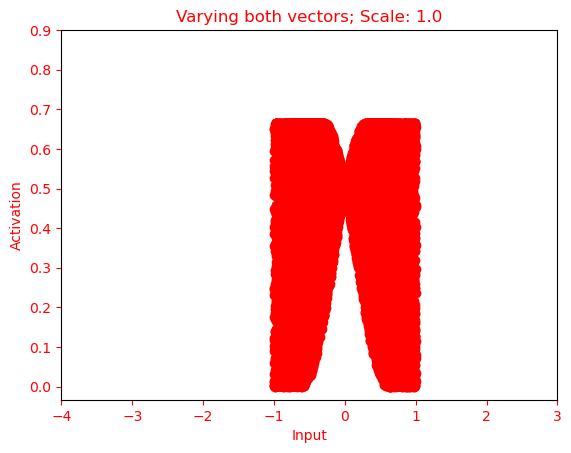

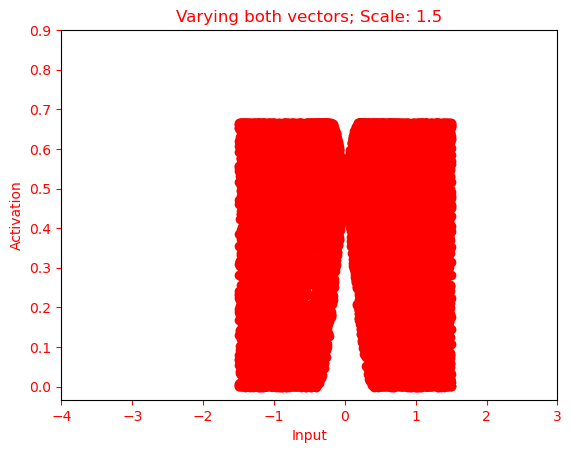

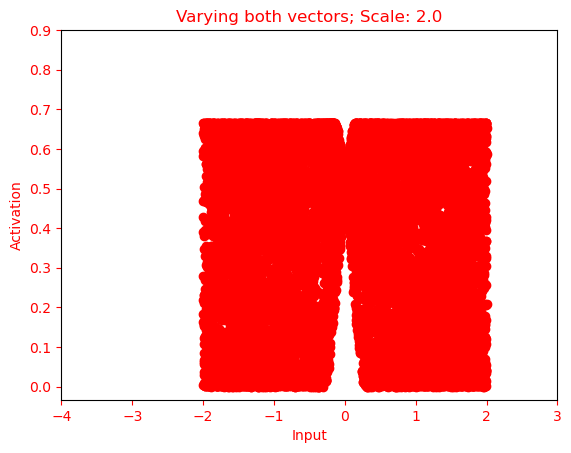

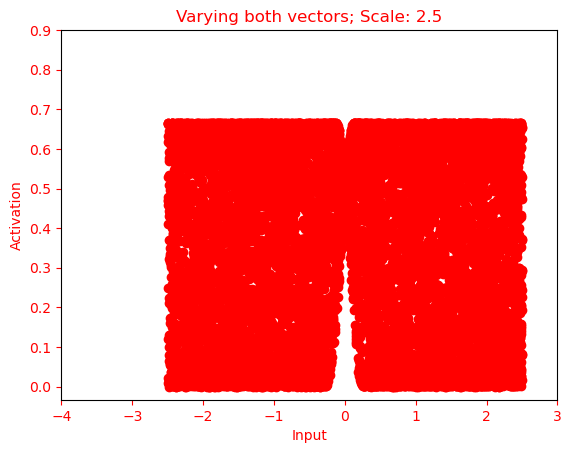

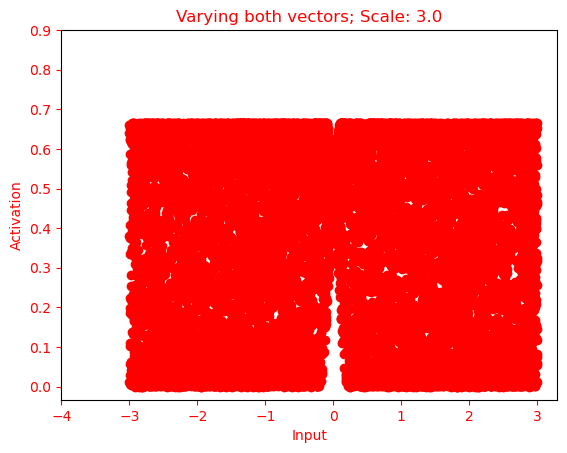

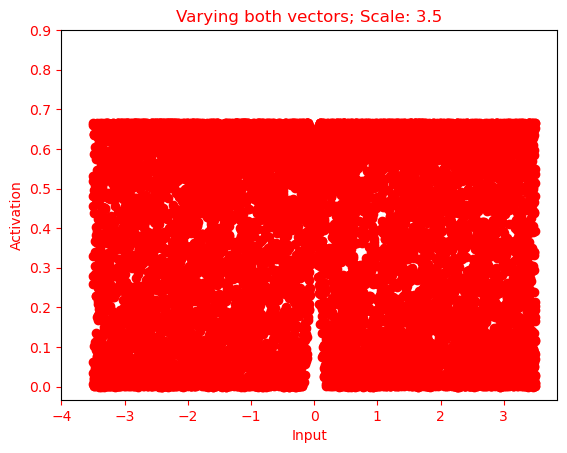

Wall time: 25.7 s


In [48]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(0.5, 4, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation)
        plt.title("Varying " + vary + "; Scale: " + str(n), color = "red")
        plot_graph(list_of_x, list_of_y)

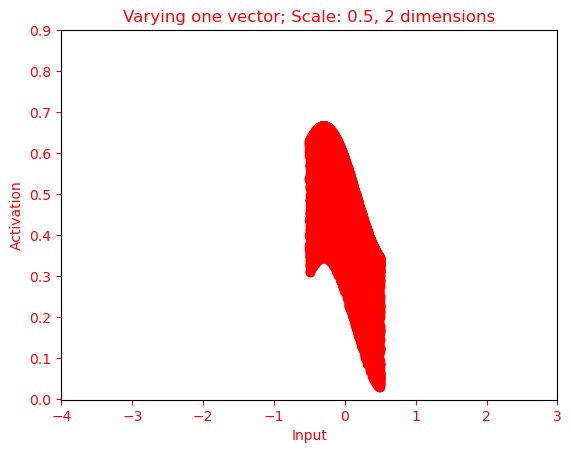

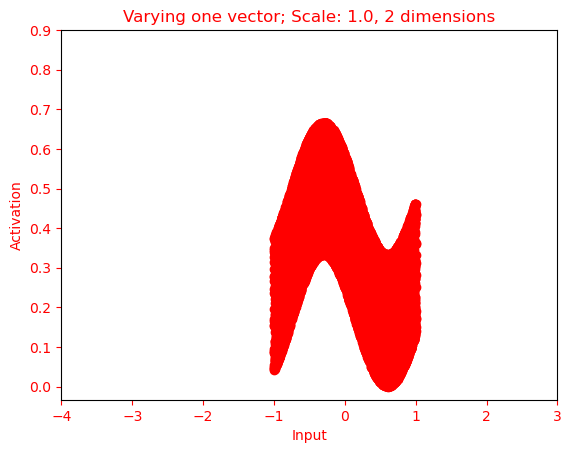

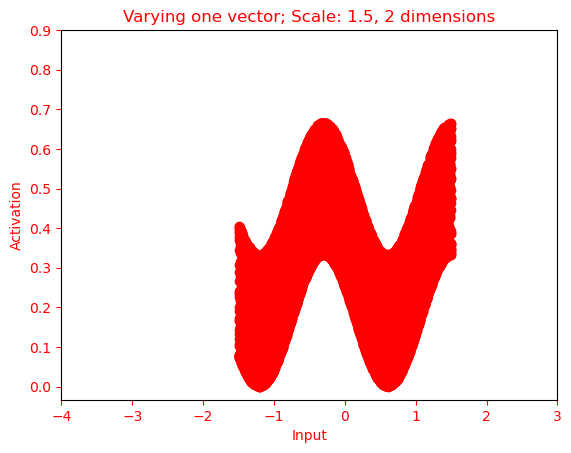

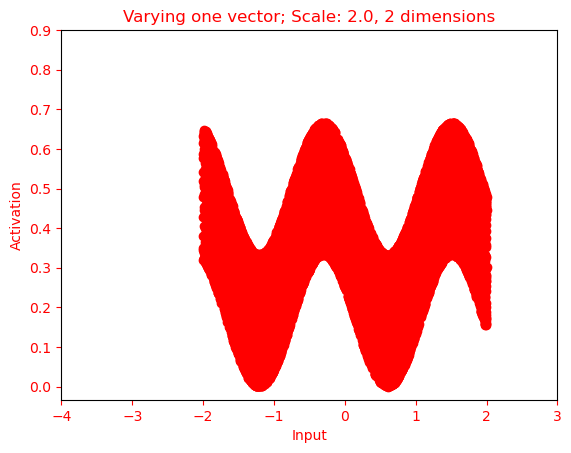

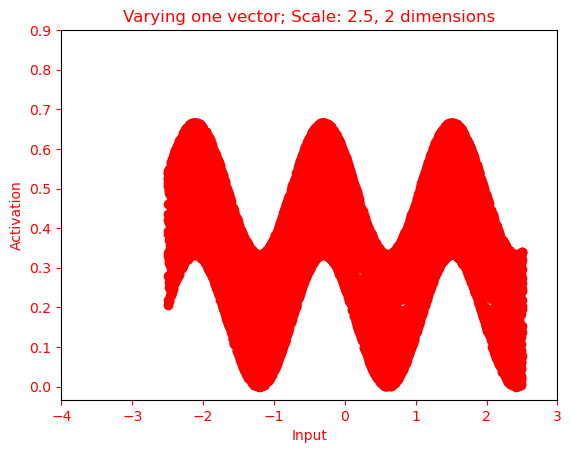

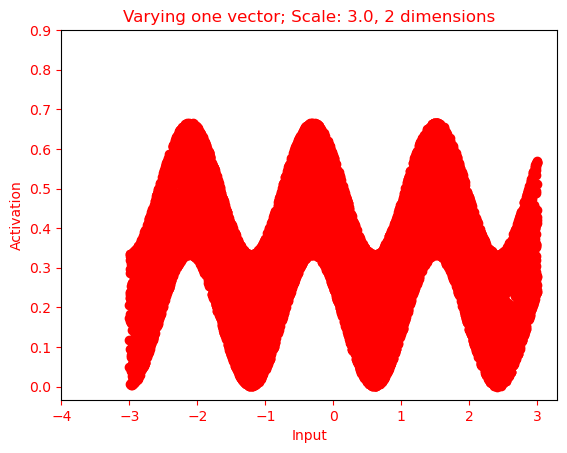

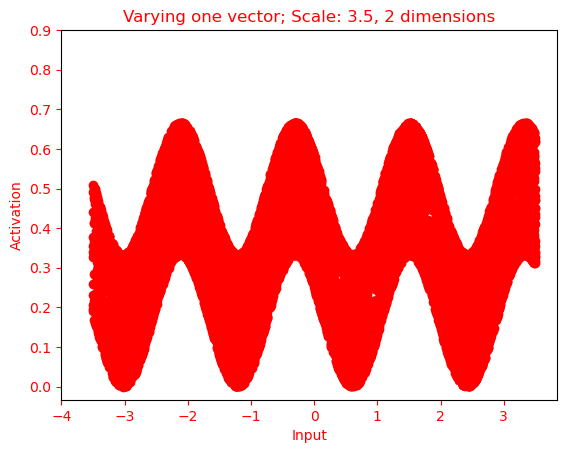

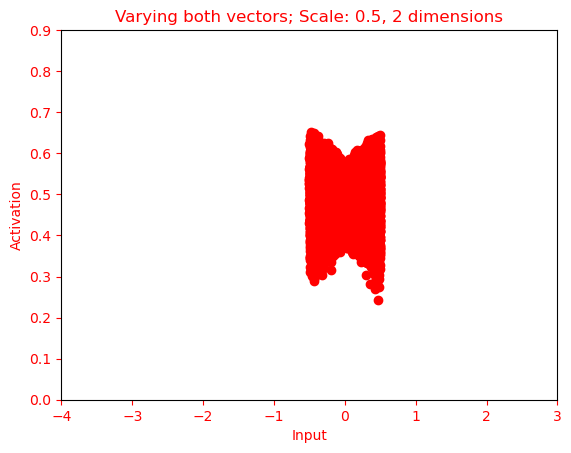

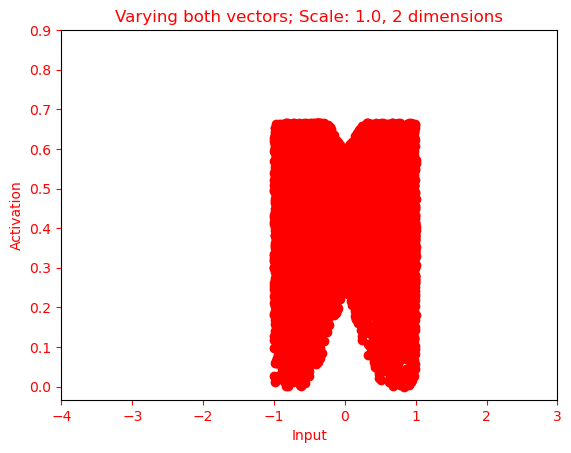

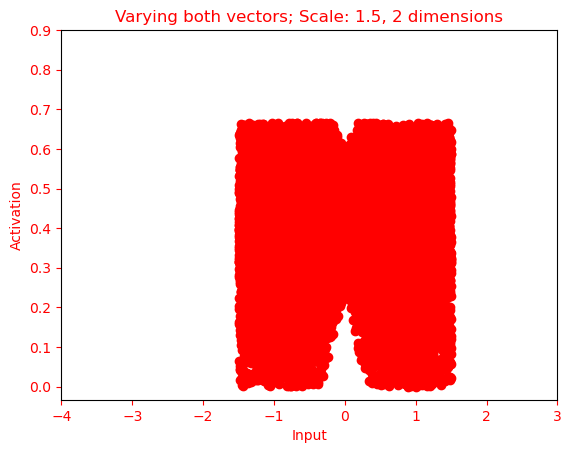

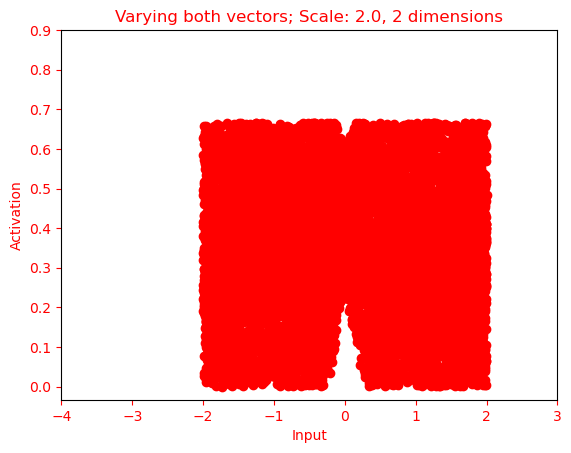

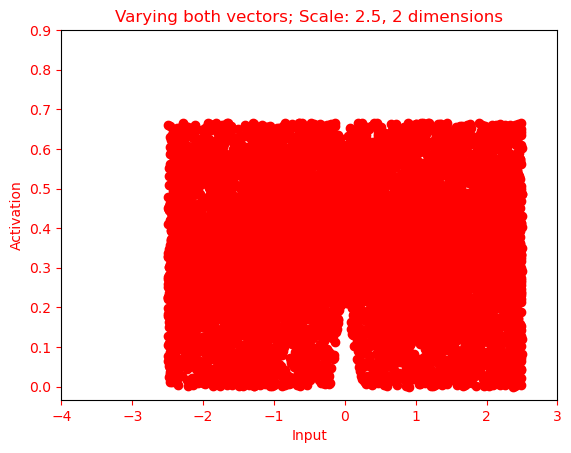

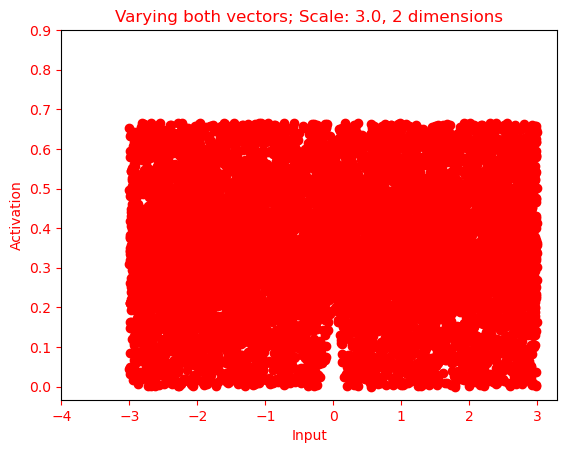

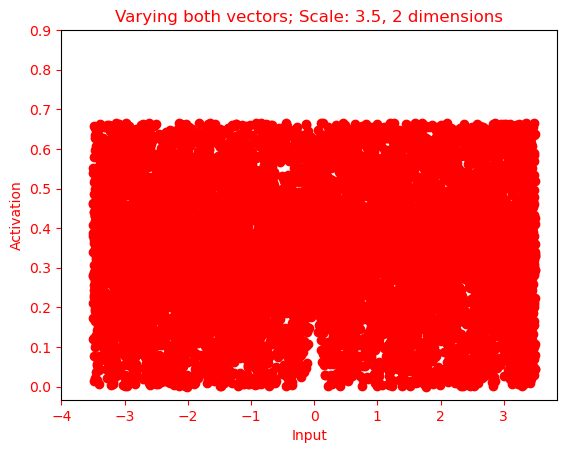

Wall time: 21.3 s


In [49]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(0.5, 4, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, dimensions=2, varied_part=variation)
        plt.title("Varying " + vary + "; Scale: " + str(n) + ", 2 dimensions", color = "red")
        plot_graph(list_of_x, list_of_y)

In [50]:
import sympy
from sympy.abc import a, b, x, y
from sympy import Matrix, exp, simplify, lambdify, Trace
from sympy.physics.quantum.trace import Tr
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum import TensorProduct

In [51]:
calc_fun_1_dim = None
calc_fun_2_dim = None

def calculated_fun(i_n, w_n):
    global calc_fun_1_dim, calc_fun_2_dim
    if calc_fun_1_dim != None and len(i_n) == 1:
        result = calc_fun_1_dim(i_n[0], w_n[0])
    elif calc_fun_2_dim != None and len(i_n) == 2:
        result = calc_fun_2_dim(i_n[0], i_n[1], w_n[0], w_n[1])
    else:
        sigma_q_sympy = Matrix([
            [1, (1 - 1j)],
            [(1j + 1), -1]
        ])

        if (len(i_n) == 1):
            sigma_e_sympy = Matrix([[a * x]])
        else:
            sigma_e_sympy = Matrix([
                [a * x, 0],
                [0, b * y]
                ])

        sigma_e_sigma_q = 1j*TensorProduct(sigma_q_sympy, sigma_e_sympy)
        
        # TensorProduct = Kroenecker product: https://docs.sympy.org/latest/modules/physics/quantum/tensorproduct.html
        # exp = matrix exponential https://stackoverflow.com/questions/47240208/sympy-symbolic-matrix-exponential
        u_operator_sympy = Matrix(sigma_e_sigma_q).exp()
        
        p_cog = Matrix([
            [1/2,1/2],
            [1/2,1/2]
            ])
        
        if (len(i_n) == 1):
            p_env = Matrix([
                [1]
            ])
        else:
            p_env = Matrix([
                [1/2, 1/2],
                [1/2, 1/2],
            ])
            
        quantum_operation_sympy = u_operator_sympy * TensorProduct(p_cog, p_env) * Dagger(u_operator_sympy)
        
        if len(i_n) == 1:
            calc_fun_1_dim = lambdify([a, x], quantum_operation_sympy)
            result = calc_fun_1_dim(i_n[0], w_n[0])
        else:
            calc_fun_2_dim = lambdify([a, b, x, y], quantum_operation_sympy)
            result = calc_fun_2_dim(i_n[0], i_n[1], w_n[0], w_n[1])

    if (len(i_n) == 1):
        p_cog_00 = complex(result[0,0])
        p_cog_11 = complex(result[1,1])
    else:
        p_cog_00 = complex(result[0,0]) + complex(result[1,1])
        p_cog_11 = complex(result[2,2]) + complex(result[3,3])
    
    p_cog_00 = np.real(p_cog_00)
    p_cog_11 = np.real(p_cog_11)

    if (p_cog_00 >= p_cog_11):
        z = 0
    else:
        z = 1
    return z, p_cog_11

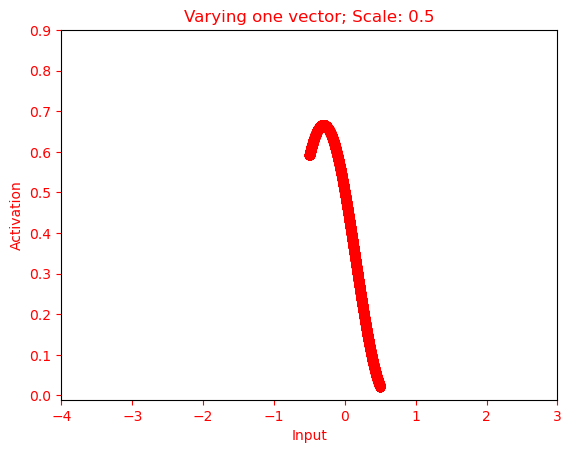

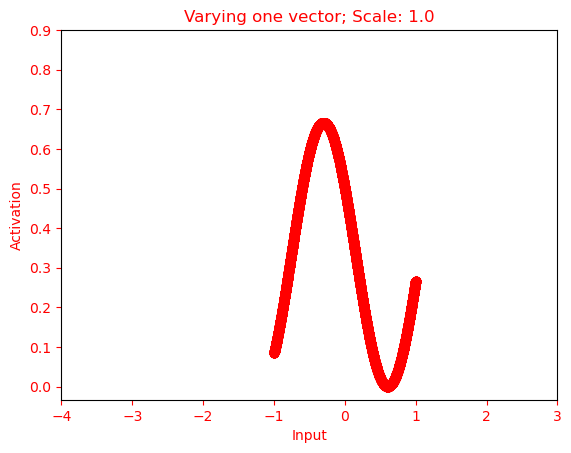

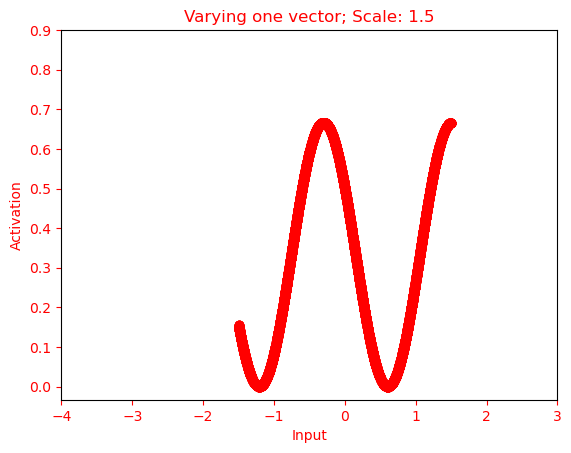

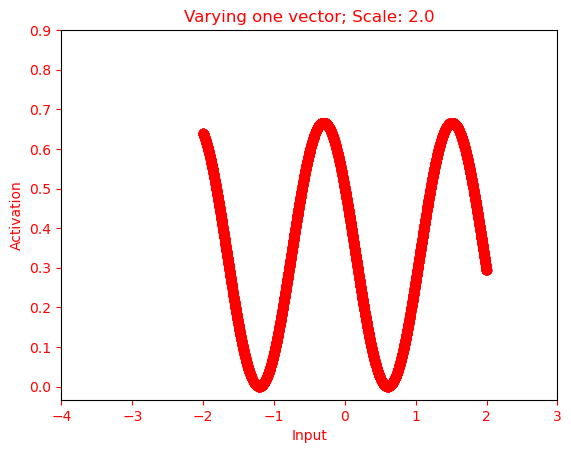

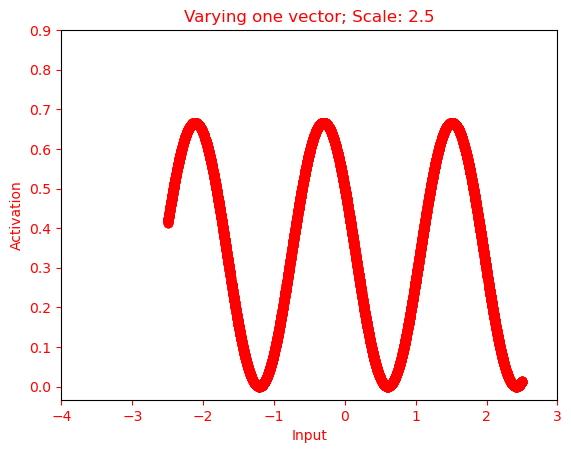

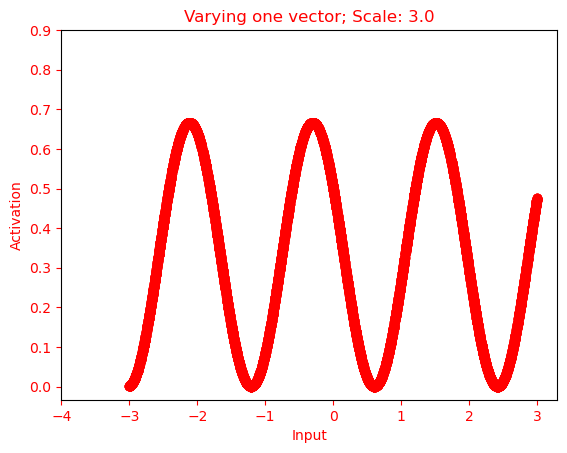

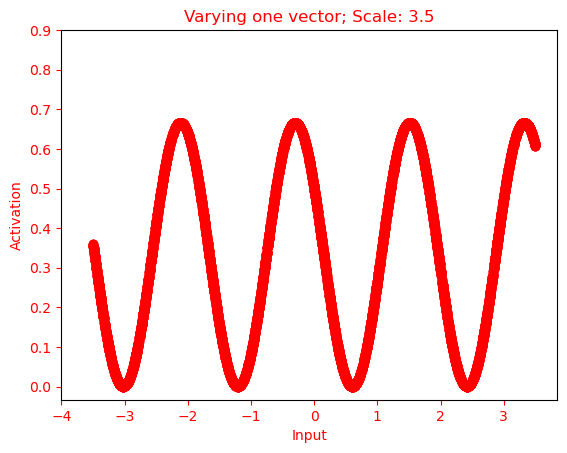

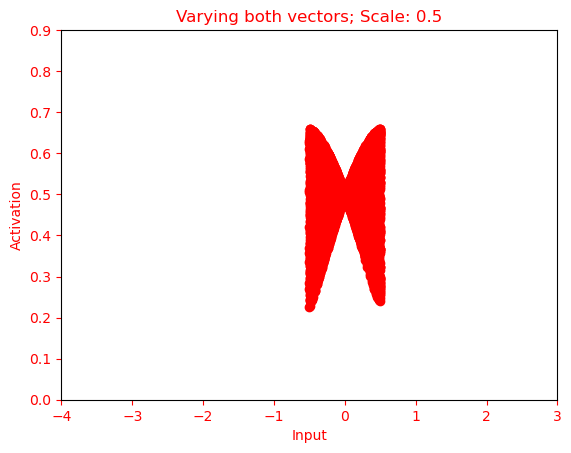

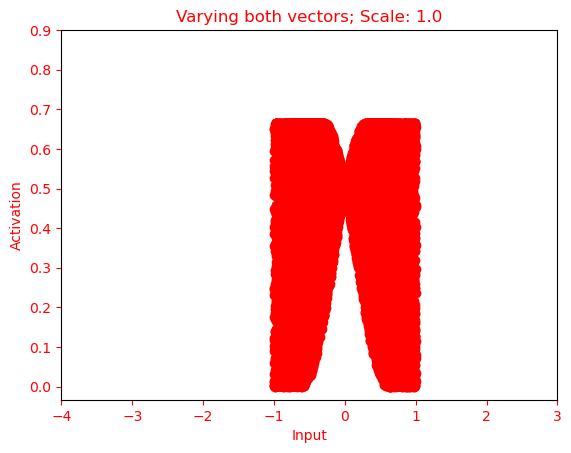

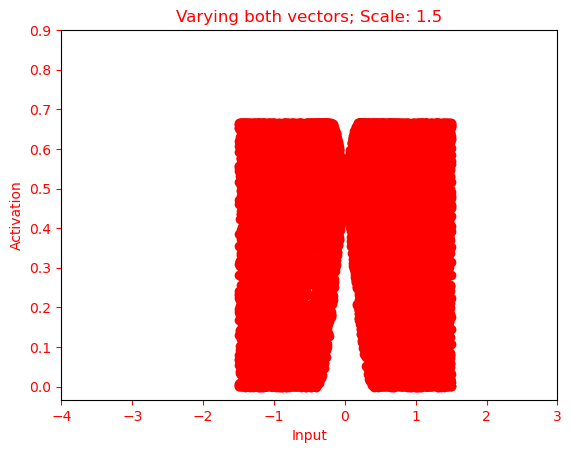

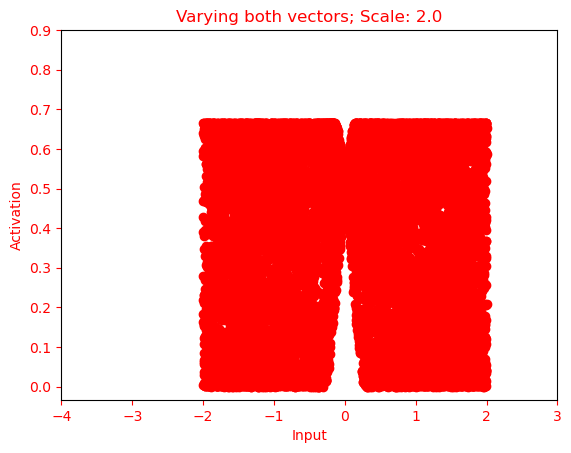

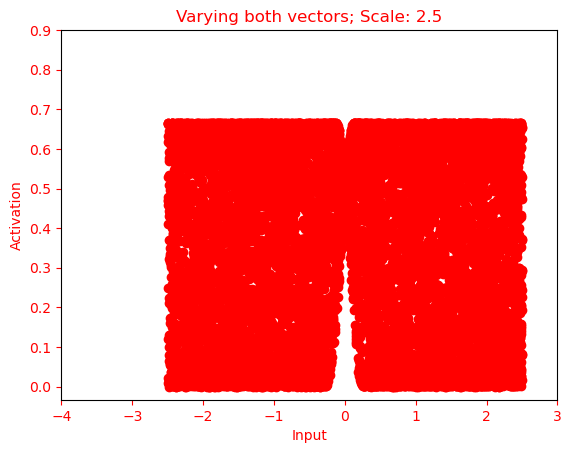

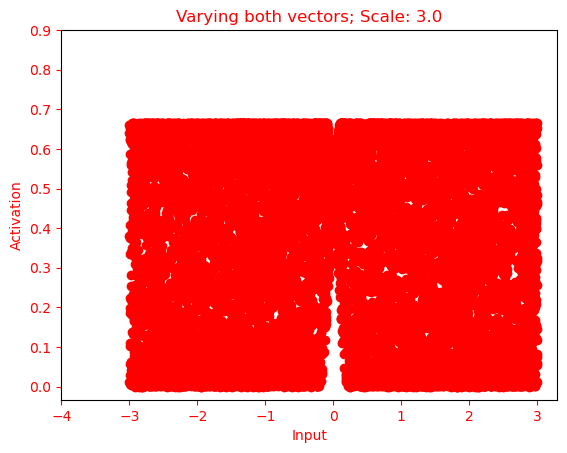

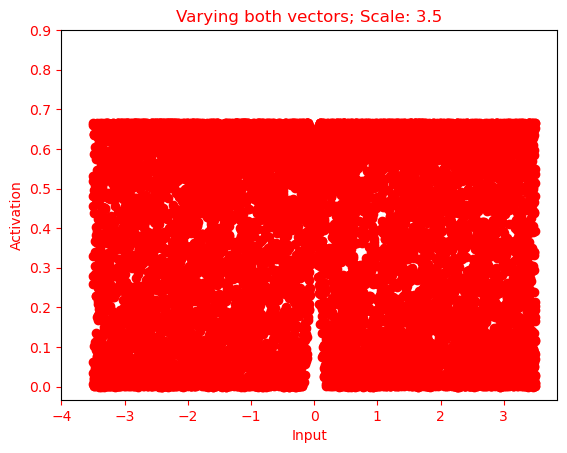

Wall time: 13.7 s


In [52]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(0.5, 4, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, output_func=calculated_fun)
        plt.title("Varying " + vary + "; Scale: " + str(n), color = "red")
        plot_graph(list_of_x, list_of_y)

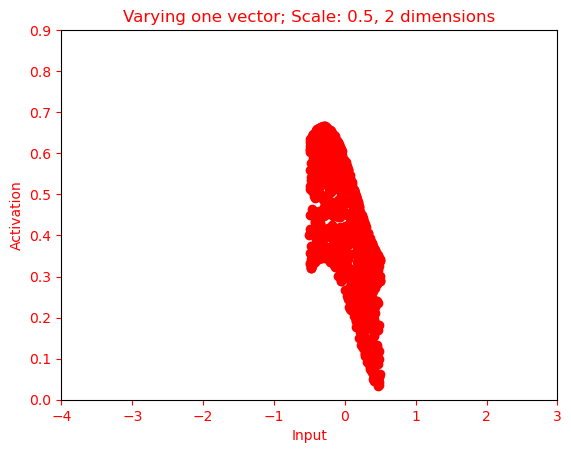

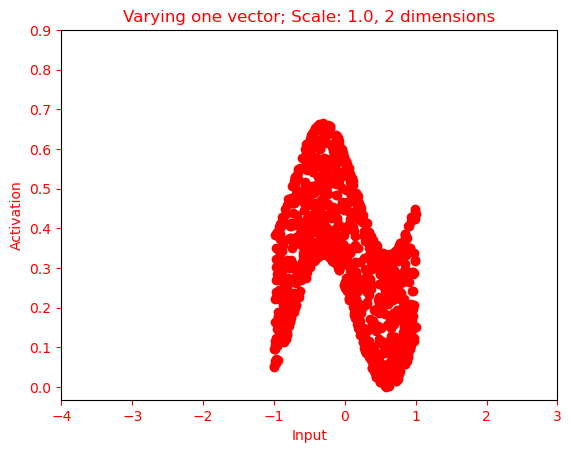

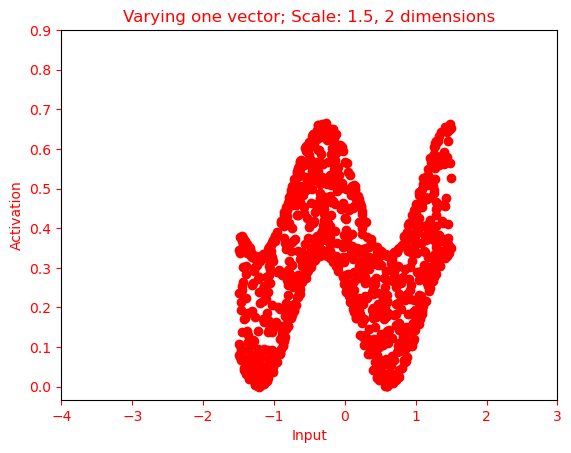

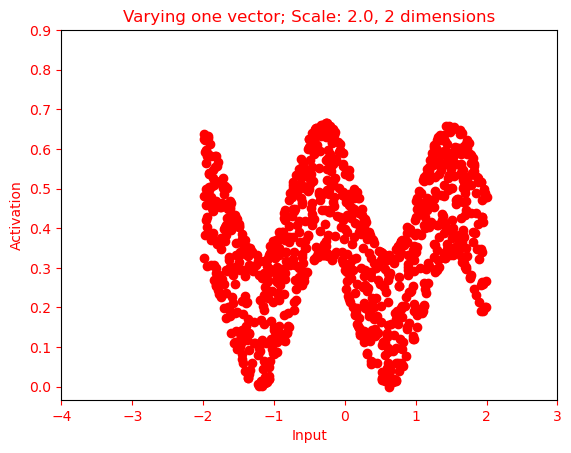

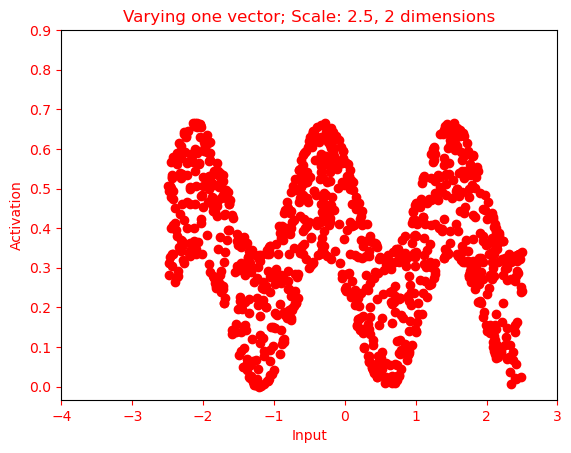

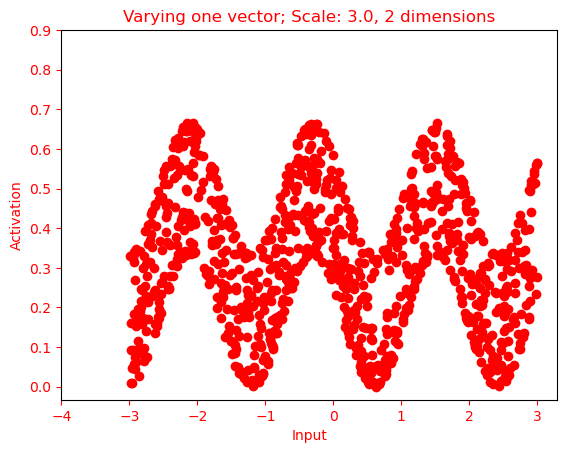

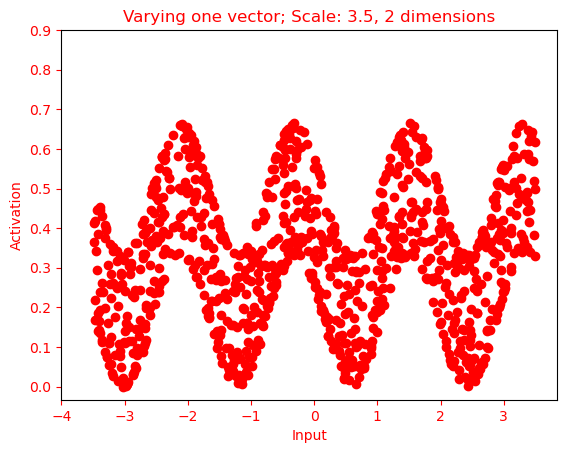

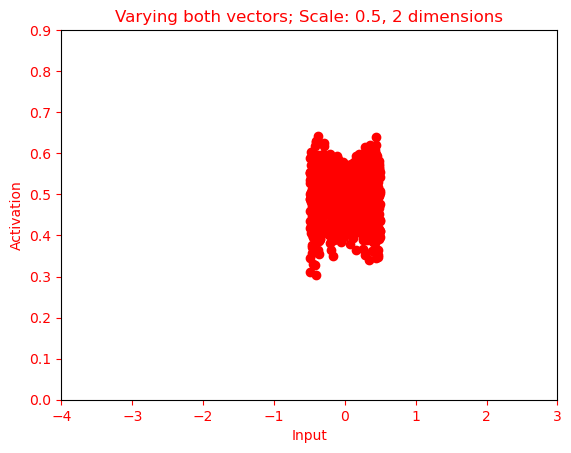

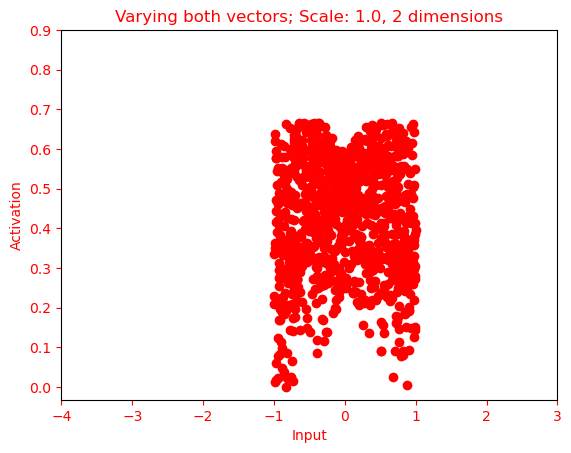

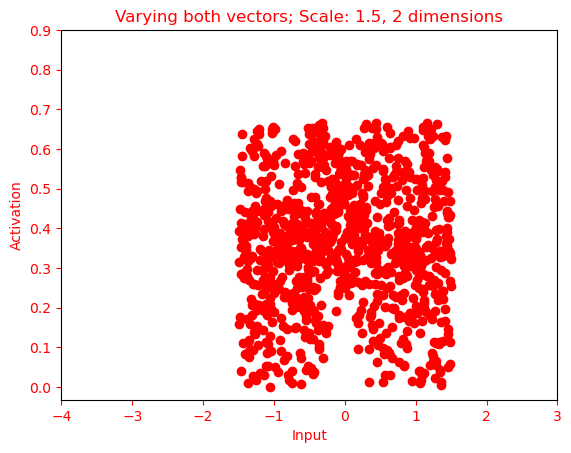

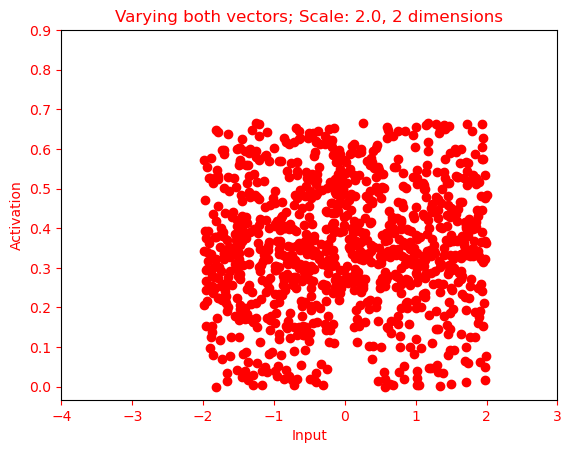

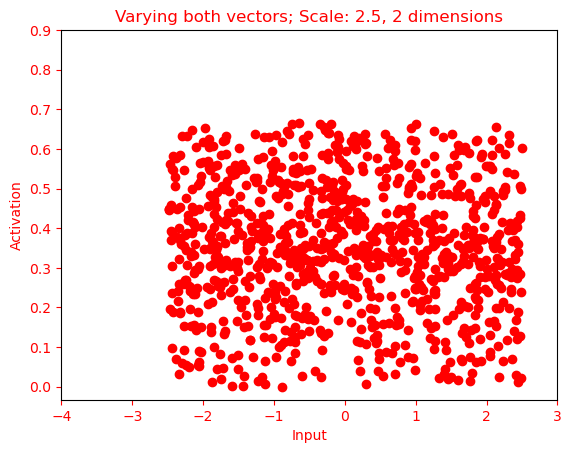

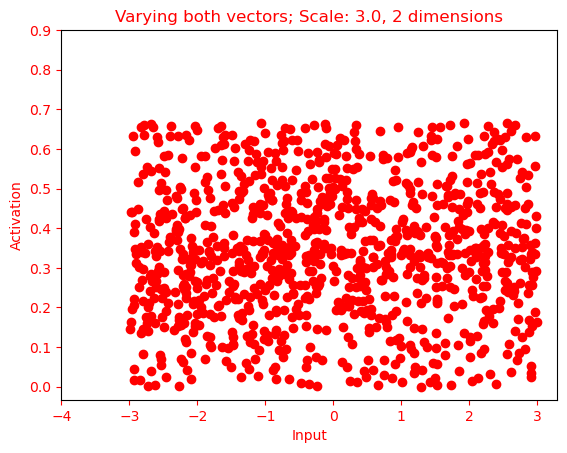

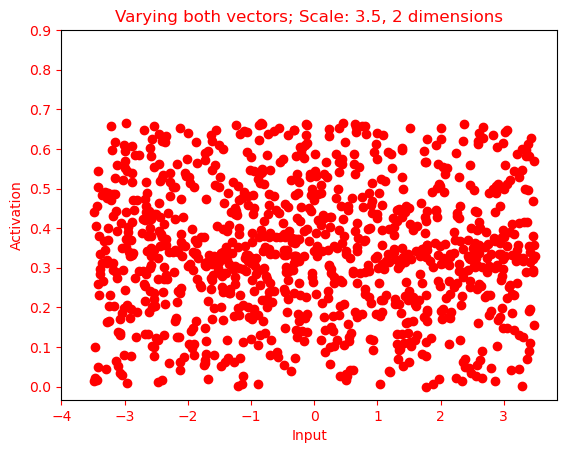

Wall time: 6.79 s


In [53]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(0.5, 4, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(1000, scale=n, varied_part=variation, dimensions=2, output_func=calculated_fun)
        plt.title("Varying " + vary + "; Scale: " + str(n) + ", 2 dimensions", color = "red")
        plot_graph(list_of_x, list_of_y)

In [54]:
def classical_neuron_output_func(i_n, w_n):
    x = np.dot(i_n, w_n)
    activation = 1 / (1 + np.exp(-x))
    return np.round(activation), activation

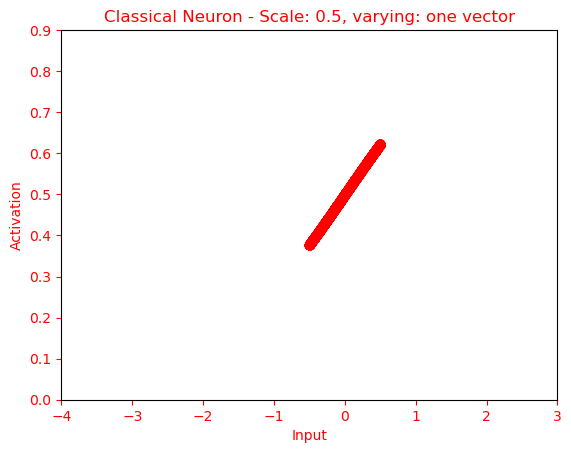

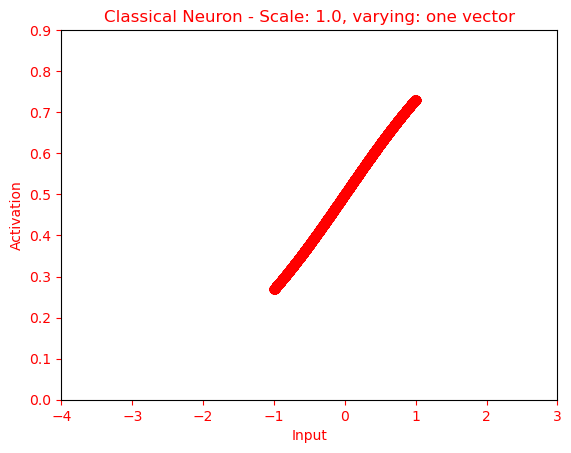

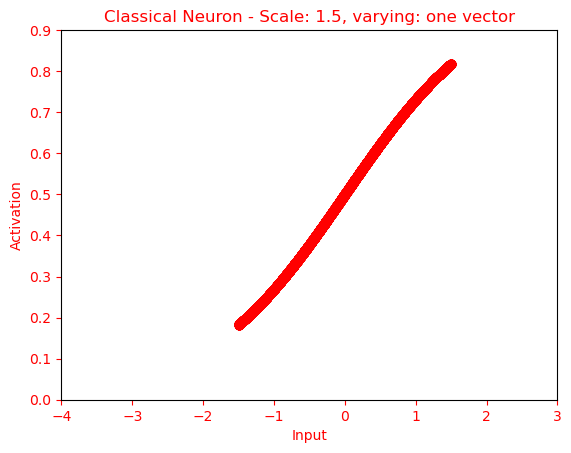

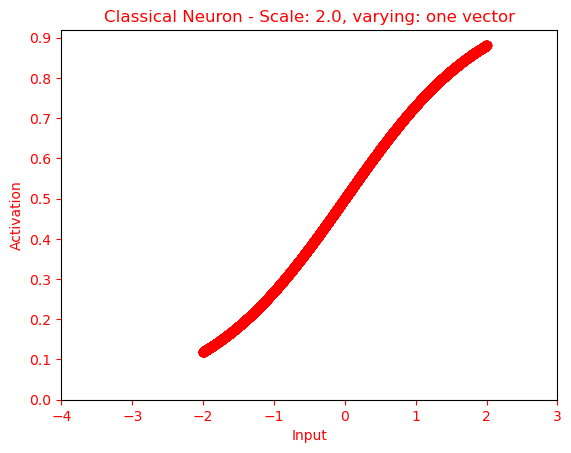

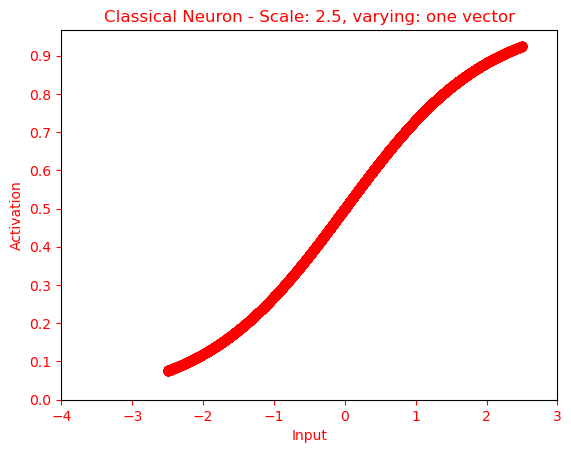

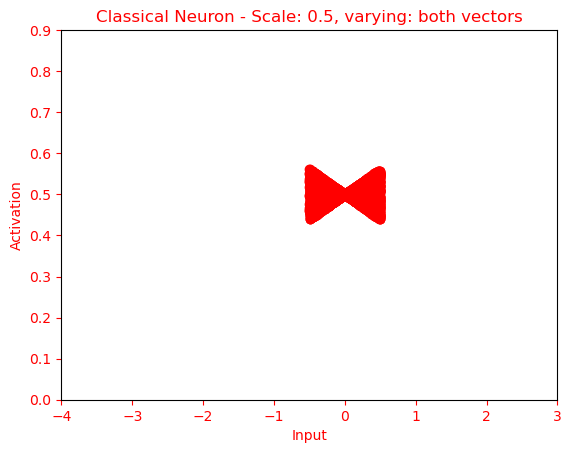

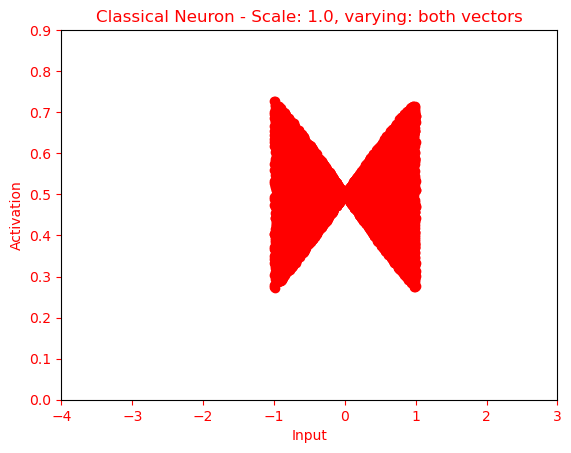

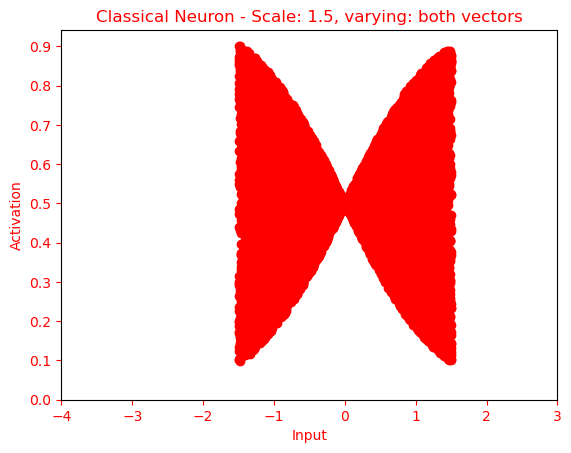

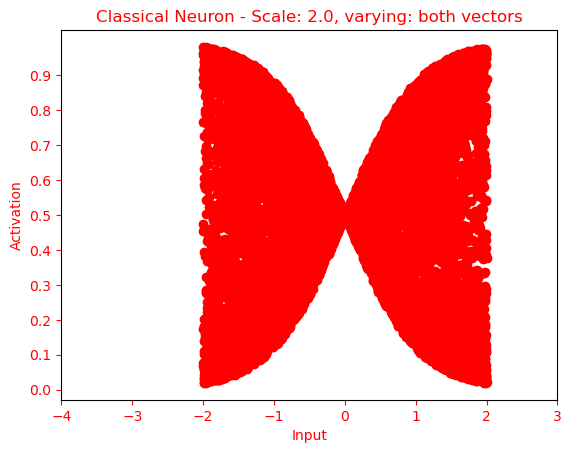

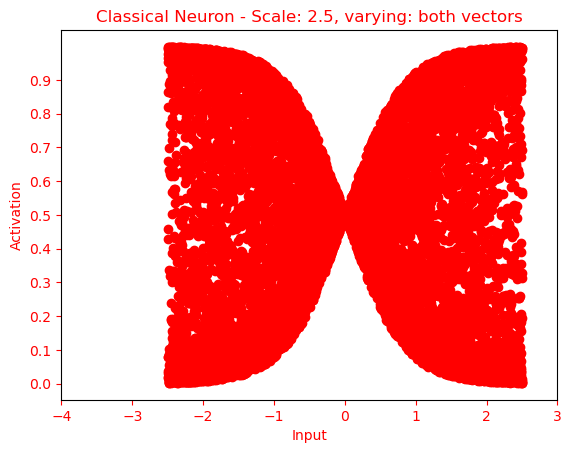

Wall time: 2.12 s


In [55]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(0.5, 3, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, output_func=classical_neuron_output_func)
        plt.title("Classical Neuron - " + "Scale: " + str(n) + ", varying: " + vary, color = "red")
        plot_graph(list_of_x, list_of_y)